# <h1>Time Series Analysis and Forecast on Irish Daily Covid Case Infection Rates</h1>

<h3>Nadia Abouelleil</h3>

<h2>Total Confirmed Covid Cases Forecast</h2>

- Importing libraries

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
warnings.filterwarnings('ignore')

- Reading data file
- Outputting the size

In [10]:
data=pd.read_csv("CovidCasesTotal.csv")
data.shape

(178, 2)

- Creating the 'Date' as a data index
- Printing the 1st 5 values of the dataset

In [11]:
data['Date']=pd.to_datetime(data['Date'], infer_datetime_format=True)
data=data.set_index(['Date'])

data.head()

,TotalConfirmedCovidCases
Date,
2020-02-29,1
2020-03-03,2
2020-03-04,6
2020-03-05,13
2020-03-06,18


- Plotting the Time Series graph of the Total Confirmed Covid Cases

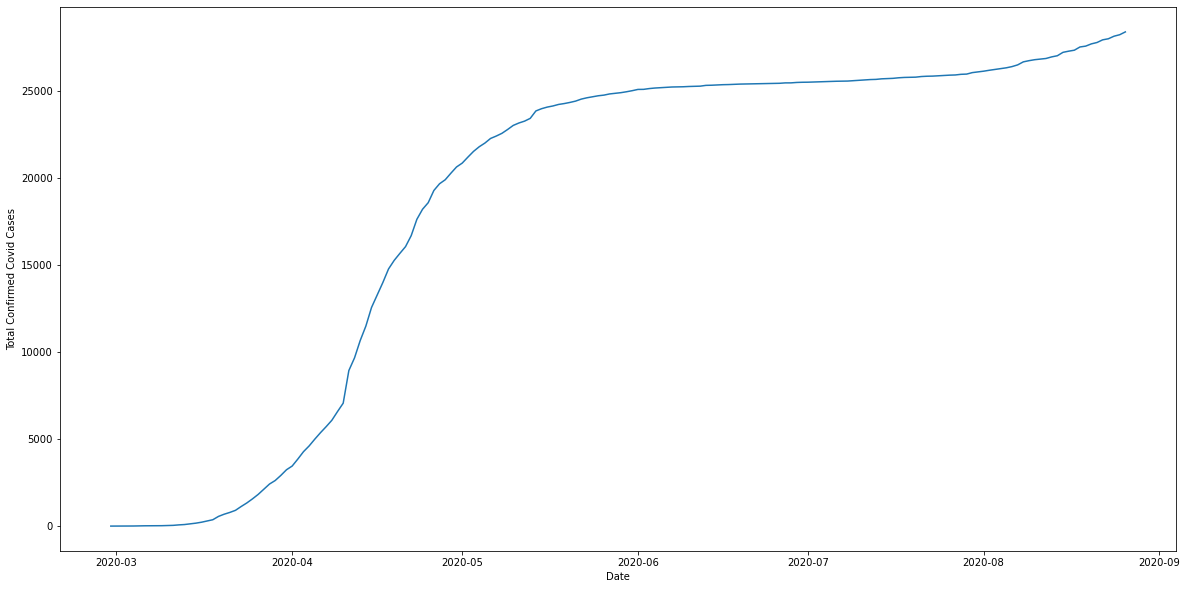

In [12]:
plt.figure(figsize=(20,10))
plt.xlabel("Date")
plt.ylabel("Total Confirmed Covid Cases")
plt.plot(data)

- Calculating the Rolling Mean and Standard Deviation of the Time Series so we can check it's stationarity 
- ** A Time Series is stationary if the mean and variance are constant

In [13]:
rolmean=data.rolling(window=12).mean()
rolstd=data.rolling(window=12).std()
print(rolmean.head(15))
print(rolstd.head(15))

            TotalConfirmedCovidCases
Date                                
2020-02-29                       NaN
2020-03-03                       NaN
2020-03-04                       NaN
2020-03-05                       NaN
2020-03-06                       NaN
2020-03-07                       NaN
2020-03-08                       NaN
2020-03-09                       NaN
2020-03-10                       NaN
2020-03-11                       NaN
2020-03-12                       NaN
2020-03-13                 28.416667
2020-03-14                 39.083333
2020-03-15                 53.000000
2020-03-16                 71.083333
            TotalConfirmedCovidCases
Date                                
2020-02-29                       NaN
2020-03-03                       NaN
2020-03-04                       NaN
2020-03-05                       NaN
2020-03-06                       NaN
2020-03-07                       NaN
2020-03-08                       NaN
2020-03-09                       NaN
2

- Plotting the Rolling Mean and Standard Deviation
- We can see the Time Series is non-stationary since the mean and variance are not constant

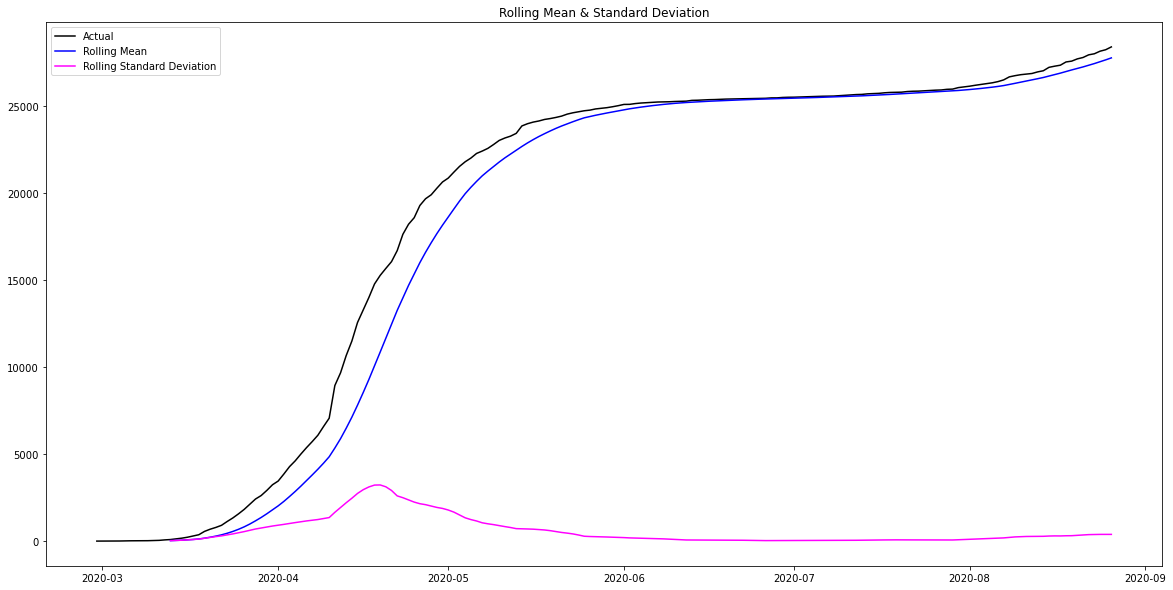

In [14]:
plt.figure(figsize=(20,10))
actual=plt.plot(data, color='black', label='Actual')
mean_6=plt.plot(rolmean, color='blue', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='magenta', label='Rolling Standard Deviation')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

- Using the Dickey-Fuller (ADF) Test to also check stationarity
- Null hypothesis = Time series is nonstationary
- Reject null hypothesis if p-value is less than 0.05 (significance level)

- Test Result: Non-Stationary

In [15]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(data['TotalConfirmedCovidCases'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','P-value','Lags Used','No. of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic               -2.407420
P-value                       0.139653
Lags Used                     4.000000
No. of Observations Used    173.000000
Critical Value (1%)          -3.468726
Critical Value (5%)          -2.878396
Critical Value (10%)         -2.575756
dtype: float64


- Making Time series stationary by logging the data
- Plotting the logged data

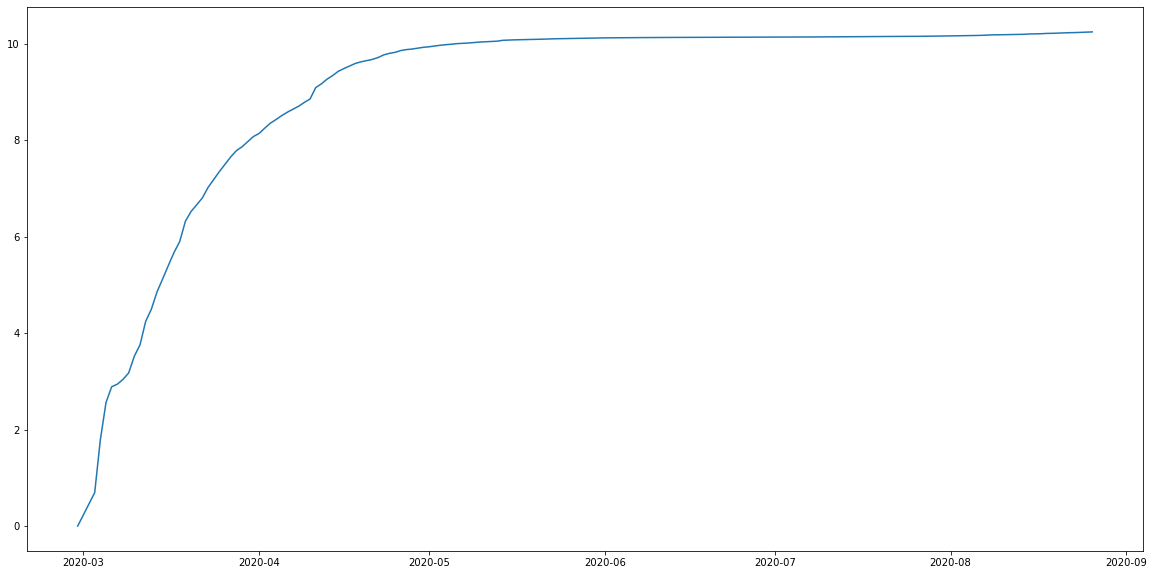

In [16]:
plt.figure(figsize=(20,10))
data_log=np.log(data)
plt.plot(data_log)

- Calculating Rolling Mean and Standard Deviation on logged time series to check stationarity
- Result: still non-stationary

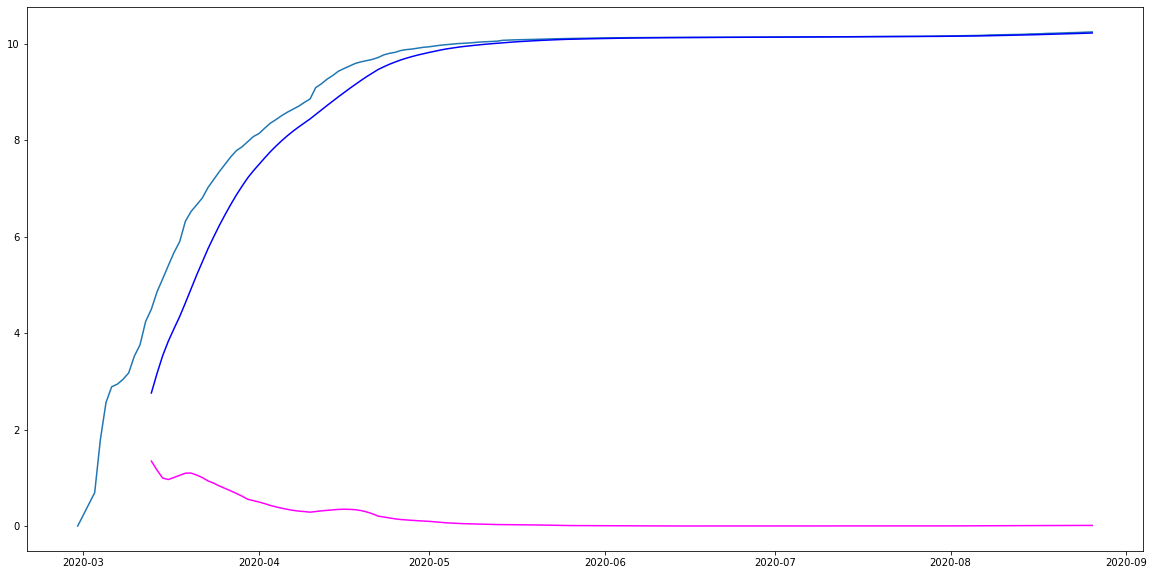

In [17]:
plt.figure(figsize=(20,10))
MAvg=data_log.rolling(window=12).mean()
MStd=data_log.rolling(window=12).std()
plt.plot(data_log)
plt.plot(MAvg, color='blue')
plt.plot(MStd, color='magenta')

- Making time series stationary using another differencing method

In [18]:
data_log_diff=data_log-MAvg
data_log_diff=data_log_diff.dropna()
data_log_diff.head()

,TotalConfirmedCovidCases
Date,
2020-03-13,1.737884
2020-03-14,1.692902
2020-03-15,1.593259
2020-03-16,1.569248
2020-03-17,1.579513


- Defining a function for the stationarity tests

In [19]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='black', label='Actual')
    mean_6=plt.plot(rolmean, color='blue', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='magenta', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['TotalConfirmedCovidCases'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

- Checking the stationarity of differenced data
- Rolling method: Mean and standard deviation varies at the start than stops varying at 2020-06
- ADF Method: Reject null hypothesis (p-value < 0.5)
- Result: Our data should now be stationary

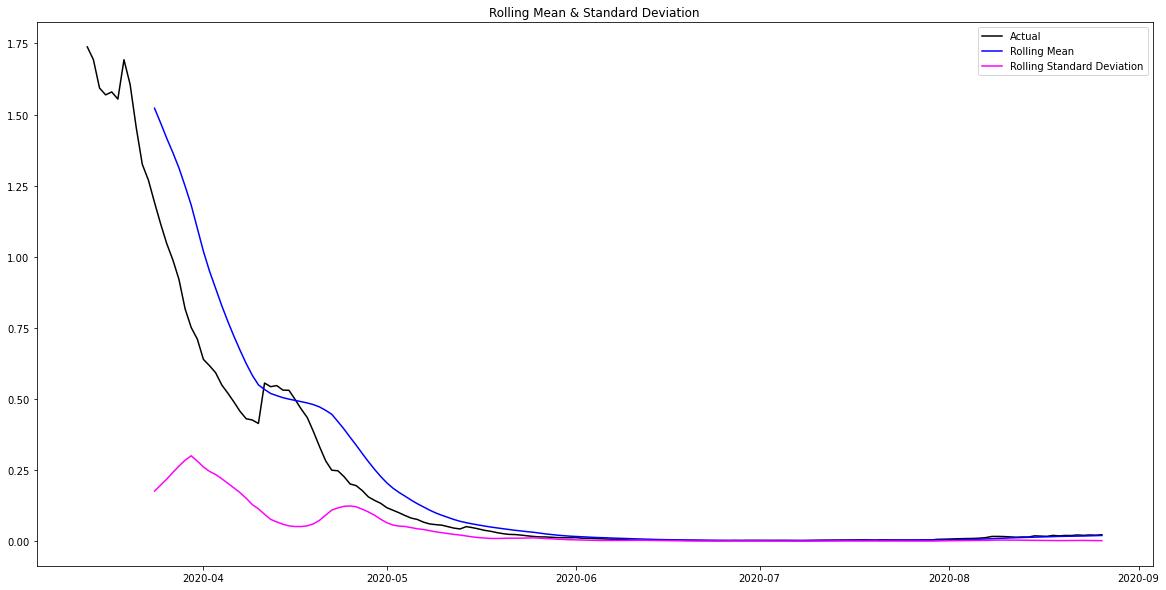

Dickey-Fuller Test: 
Test Statistic               -5.277426
p-value                       0.000006
Lags Used                    13.000000
No. of Observations Used    153.000000
Critical Value (1%)          -3.473830
Critical Value (5%)          -2.880623
Critical Value (10%)         -2.576945
dtype: float64


In [20]:
stationarity(data_log_diff)

- Checking for Trend stationarity
- Exponentially transforming the data

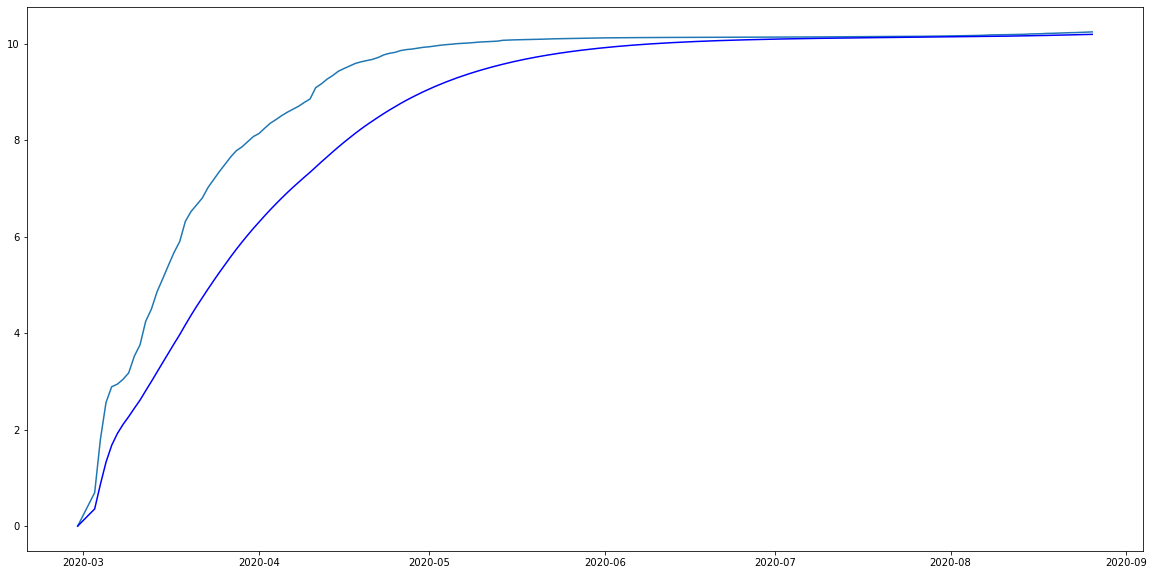

In [21]:
plt.figure(figsize=(20,10))
exp_data=data_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(data_log)
plt.plot(exp_data, color='blue')

- Differencing data to turn log transformation stationary
- Plotting the graph
- Result: Our data should now be stationary

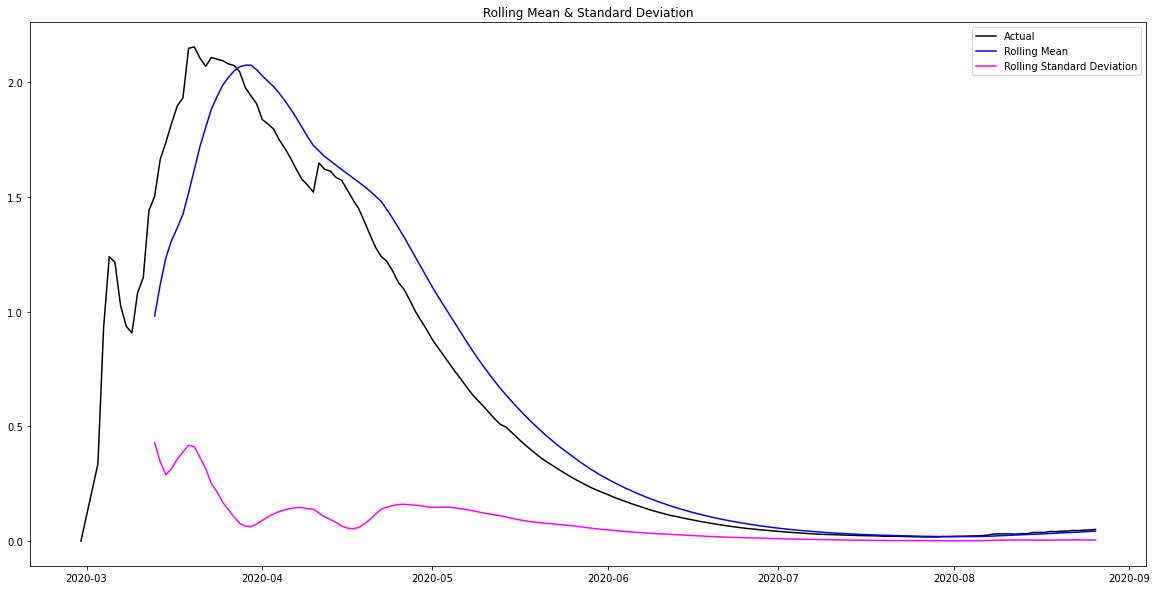

Dickey-Fuller Test: 
Test Statistic               -4.945943
p-value                       0.000028
Lags Used                    14.000000
No. of Observations Used    163.000000
Critical Value (1%)          -3.471119
Critical Value (5%)          -2.879441
Critical Value (10%)         -2.576314
dtype: float64


In [22]:
exp_data_diff=data_log-exp_data
stationarity(exp_data_diff)

- Shifting the values of the Time Series

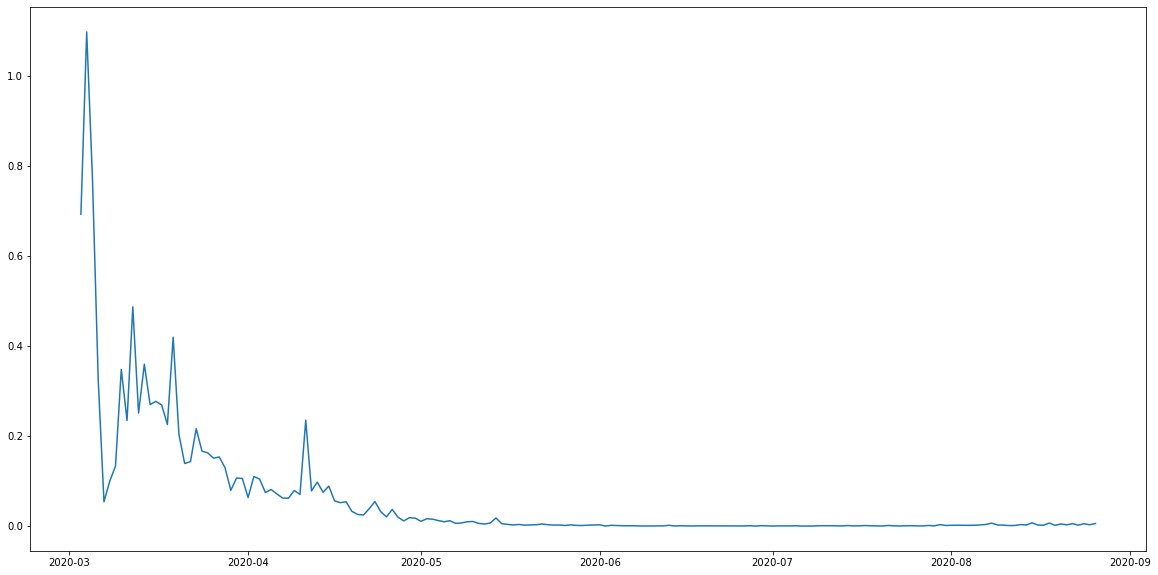

In [23]:
plt.figure(figsize=(20,10))
data_shift=data_log-data_log.shift()
plt.plot(data_shift)

- Dropping the NA values
- Testing stationarity
- Result: Our data should now be stationary

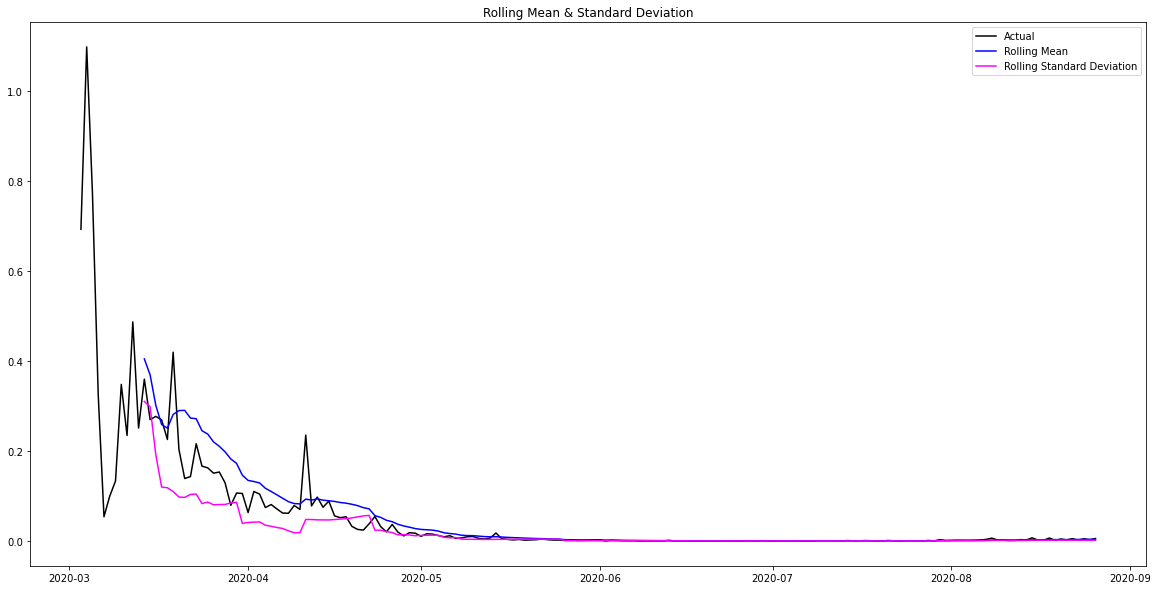

Dickey-Fuller Test: 
Test Statistic             -8.573003e+00
p-value                     8.102153e-14
Lags Used                   1.400000e+01
No. of Observations Used    1.620000e+02
Critical Value (1%)        -3.471374e+00
Critical Value (5%)        -2.879552e+00
Critical Value (10%)       -2.576373e+00
dtype: float64


In [24]:
data_shift=data_shift.dropna()
stationarity(data_shift)

- Decomposing Time Series to see its Trend, Seasonality & Residual

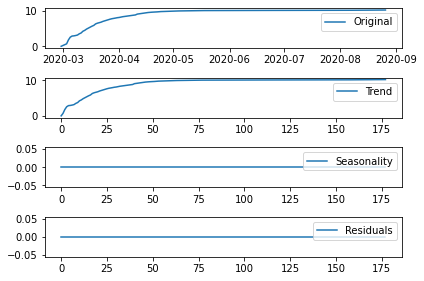

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(data_log.values, freq=1)

trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Plotting ACF and PACF to find q and p value
- ACF = Auto-Correlation Function
- PACF = Partial Auto-Correlation Function

Text(0.5, 1.0, 'Autocorrelation Function')

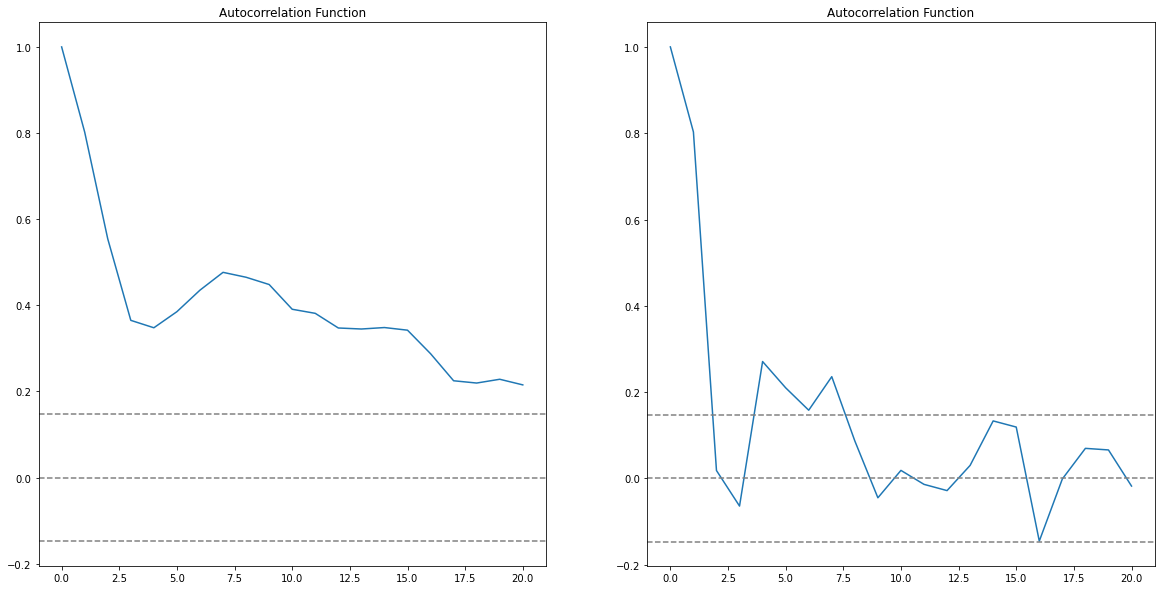

In [138]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(data_shift, nlags=20)
lag_pacf=pacf(data_shift, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(data_shift)),linestyle='--',color='grey')
plt.axhline(y=1.96/np.sqrt(len(data_shift)),linestyle='--',color='grey')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(data_shift)),linestyle='--',color='grey')
plt.axhline(y=1.96/np.sqrt(len(data_shift)),linestyle='--',color='grey')
plt.title('Autocorrelation Function')

- Creating ARIMA model with p=2, q=2 and I=1

plotting ARIMA model


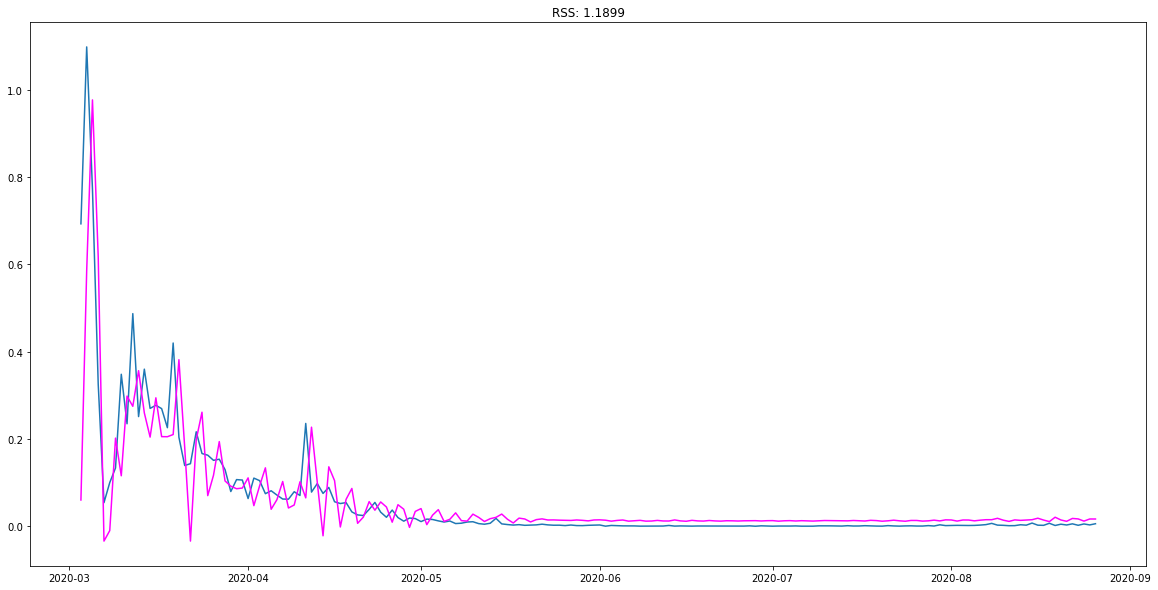

In [129]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(data_log, order=(2,1,2))
results=model.fit(disp=-1)
plt.plot(data_shift)
plt.plot(results.fittedvalues, color='magenta')
plt.title('RSS: %.4f'% sum((results.fittedvalues-data_shift['TotalConfirmedCovidCases'])**2))
print('plotting ARIMA model')

- Predicted values from ARIMA model in difference form

In [106]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Date
2020-03-03    0.060115
2020-03-04    0.585762
2020-03-05    0.977139
2020-03-06    0.617274
2020-03-07   -0.034045
dtype: float64


- Inverse Transformation for differencing using cumulative sum

In [107]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Date
2020-03-03    0.060115
2020-03-04    0.645878
2020-03-05    1.623016
2020-03-06    2.240290
2020-03-07    2.206245
dtype: float64


- Predicted values in log scale

In [177]:
predictions_log=pd.Series(data_log['TotalConfirmedCovidCases'].iloc[0], index=data_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

predictions_log=pd.Series(data_log['TotalConfirmedCovidCases'].iloc[0], index=data_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

Date
2020-02-29    0.000000
2020-03-03    0.060115
2020-03-04    0.645878
2020-03-05    1.623016
2020-03-06    2.240290
dtype: float64

- Removing log transformation
- Plotting actual vs predicted value graph

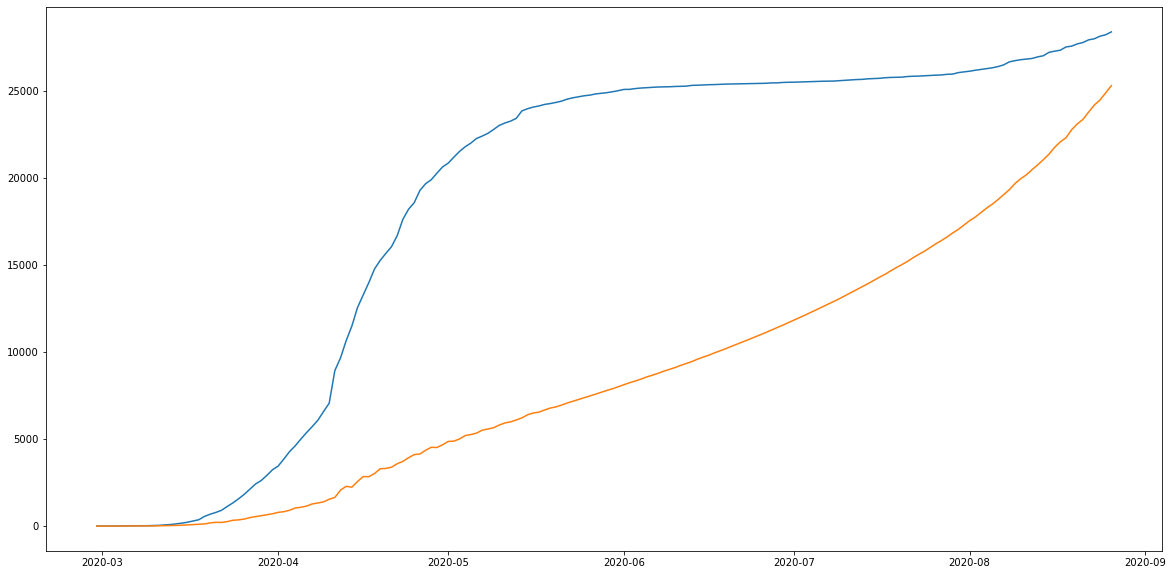

In [34]:
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(20,10))
plt.plot(data)
plt.plot(predictions_ARIMA)

- Plotting the Time Series forecast of the next 4 months with 95% confidence interval

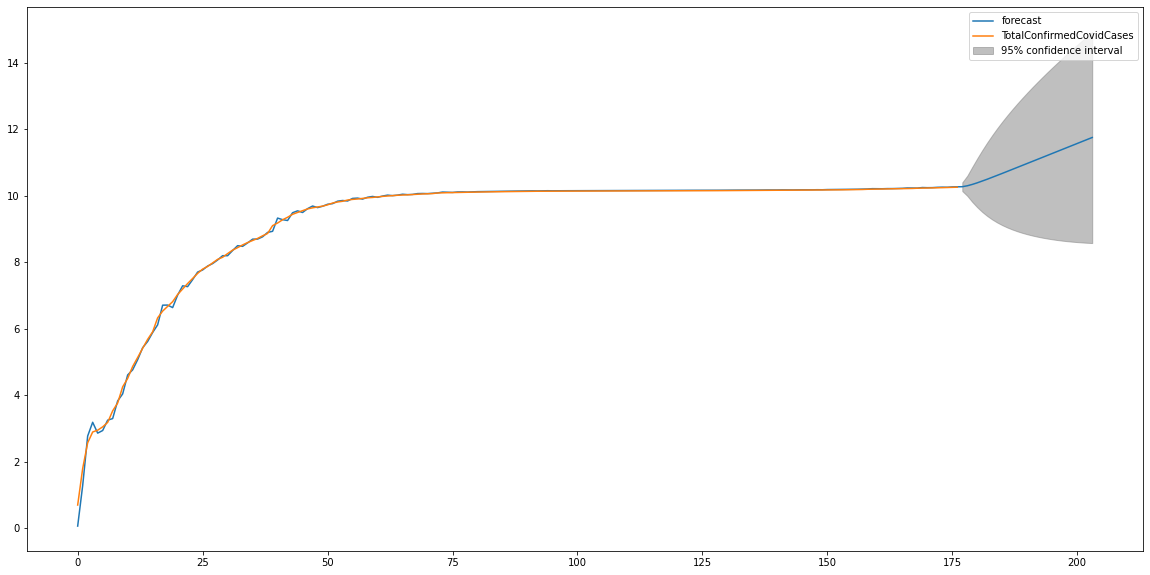

In [134]:
rcParams['figure.figsize']=20,10
results.plot_predict(1,204)
x=results.forecast(steps=120)

- Forecasted results in data form of the next 4 months

In [110]:
results.forecast(steps=120)

(array([10.26742312, 10.29509869, 10.33621472, 10.38440277, 10.4372197 ,
        10.49282733, 10.55016806, 10.60857344, 10.66763545, 10.72710186,
        10.78681744, 10.84668653, 10.90665021, 10.96667215, 11.02672999,
        11.08680995, 11.14690354, 11.20700552, 11.26711268, 11.32722302,
        11.38733532, 11.44744884, 11.50756309, 11.56767781, 11.62779281,
        11.68790799, 11.74802327, 11.80813862, 11.86825401, 11.92836943,
        11.98848486, 12.0486003 , 12.10871574, 12.16883119, 12.22894664,
        12.2890621 , 12.34917755, 12.409293  , 12.46940846, 12.52952391,
        12.58963937, 12.64975482, 12.70987028, 12.76998573, 12.83010119,
        12.89021664, 12.9503321 , 13.01044755, 13.07056301, 13.13067846,
        13.19079392, 13.25090937, 13.31102483, 13.37114029, 13.43125574,
        13.4913712 , 13.55148665, 13.61160211, 13.67171756, 13.73183302,
        13.79194847, 13.85206393, 13.91217938, 13.97229484, 14.03241029,
        14.09252575, 14.1526412 , 14.21275666, 14.2